The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1
!pip install -U mxnet-cu101==1.7.0


# Máquinas de Fatoração Profunda

Aprender combinações eficazes de recursos é fundamental para o sucesso da tarefa de previsão da taxa de cliques. As máquinas de fatoração modelam interações de recursos em um paradigma linear (por exemplo, interações bilineares). Isso geralmente é insuficiente para dados do mundo real, onde as estruturas de cruzamento de recursos inerentes são geralmente muito complexas e não lineares. O que é pior, as interações de recursos de segunda ordem geralmente são usadas em máquinas de fatoração na prática. A modelagem de graus mais elevados de combinações de recursos com máquinas de fatoração é possível teoricamente, mas geralmente não é adotada devido à instabilidade numérica e à alta complexidade computacional.

Uma solução eficaz é usar redes neurais profundas. Redes neurais profundas são poderosas no aprendizado de representação de recursos e têm o potencial de aprender interações sofisticadas de recursos. Como tal, é natural integrar redes neurais profundas a máquinas de fatoração. Adicionar camadas de transformação não linear às máquinas de fatoração oferece a capacidade de modelar combinações de recursos de ordem inferior e combinações de recursos de ordem superior. Além disso, estruturas inerentes não lineares de entradas também podem ser capturadas com redes neurais profundas. Nesta seção, apresentaremos um modelo representativo denominado máquinas de fatoração profunda (DeepFM) :cite:`Guo.Tang.Ye.ea.2017` que combinam FM e redes neurais profundas.


## Arquiteturas modelo

O DeepFM consiste em um componente FM e um componente profundo que são integrados em uma estrutura paralela. O componente FM é o mesmo que as máquinas de fatoração de 2 vias que são usadas para modelar as interações de recursos de ordem inferior. O componente profundo é um perceptron de várias camadas que é usado para capturar interações de recursos de alta ordem e não linearidades. Esses dois componentes compartilham as mesmas entradas/embeddings e suas saídas são somadas como a previsão final. É importante ressaltar que o espírito do DeepFM se assemelha ao da arquitetura Wide \& Deep, que pode capturar tanto a memorização quanto a generalização. As vantagens do DeepFM sobre o modelo Wide \& Deep é que ele reduz o esforço da engenharia de recursos feita à mão, identificando combinações de recursos automaticamente.

Omitimos a descrição do componente FM por questões de brevidade e denotamos a saída como $\hat{y}^{(FM)}$. Os leitores devem consultar a última seção para obter mais detalhes. Seja $\mathbf{e}_i \in \mathbb{R}^{k}$ o vetor de característica latente do campo $i^\mathrm{th}$. A entrada do componente profundo é a concatenação dos embeddings densos de todos os campos que são pesquisados ​​com a entrada de recurso categórico esparso, denotado como:

$$
\mathbf{z}^{(0)}  = [\mathbf{e}_1, \mathbf{e}_2, ..., \mathbf{e}_f],
$$

onde $f$ é o número de campos. Em seguida, é alimentado na seguinte rede neural:

$$
\mathbf{z}^{(l)}  = \alpha(\mathbf{W}^{(l)}\mathbf{z}^{(l-1)} + \mathbf{b}^{(l)}),
$$

onde $\alpha$ é a função de ativação. $\mathbf{W}_{l}$ e $\mathbf{b}_{l}$ são o peso e o viés na camada $l^\mathrm{th}$. Seja $y_{DNN}$ a saída da previsão. A previsão final do DeepFM é a soma das saídas de FM e DNN. Então nós temos:

$$
\hat{y} = \sigma(\hat{y}^{(FM)} + \hat{y}^{(DNN)}),
$$

onde $\sigma$ é a função sigmóide. A arquitetura do DeepFM é ilustrada abaixo.
![Ilustração do modelo DeepFM](../img/rec-deepfm.svg)

É importante notar que DeepFM não é a única maneira de combinar redes neurais profundas com FM. Também podemos adicionar camadas não lineares sobre as interações de recursos :cite:`He.Chua.2017`.


In [1]:
import os
from mxnet import gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

## Implementação de DeepFM
A implementação do DeepFM é semelhante à do FM. Mantemos a parte FM inalterada e usamos um bloco MLP com `relu` como a função de ativação. O dropout também é usado para regularizar o modelo. O número de neurônios do MLP pode ser ajustado com o hiperparâmetro `mlp_dims`.


In [2]:
class DeepFM(nn.Block):
    def __init__(self, field_dims, num_factors, mlp_dims, drop_rate=0.1):
        super(DeepFM, self).__init__()
        num_inputs = int(sum(field_dims))
        self.embedding = nn.Embedding(num_inputs, num_factors)
        self.fc = nn.Embedding(num_inputs, 1)
        self.linear_layer = nn.Dense(1, use_bias=True)
        input_dim = self.embed_output_dim = len(field_dims) * num_factors
        self.mlp = nn.Sequential()
        for dim in mlp_dims:
            self.mlp.add(nn.Dense(dim, 'relu', True, in_units=input_dim))
            self.mlp.add(nn.Dropout(rate=drop_rate))
            input_dim = dim
        self.mlp.add(nn.Dense(in_units=input_dim, units=1))

    def forward(self, x):
        embed_x = self.embedding(x)
        square_of_sum = np.sum(embed_x, axis=1) ** 2
        sum_of_square = np.sum(embed_x ** 2, axis=1)
        inputs = np.reshape(embed_x, (-1, self.embed_output_dim))
        x = self.linear_layer(self.fc(x).sum(1)) \
            + 0.5 * (square_of_sum - sum_of_square).sum(1, keepdims=True) \
            + self.mlp(inputs)
        x = npx.sigmoid(x)
        return x

## Treinamento e avaliação do modelo
O processo de carregamento de dados é o mesmo do FM. Definimos o componente MLP do DeepFM para uma rede densa de três camadas com uma estrutura de pirâmide (30-20-10). Todos os outros hiperparâmetros permanecem iguais aos de FM.


loss 0.509, train acc 0.365, test acc 0.348
65671.8 examples/sec on [gpu(0), gpu(1)]


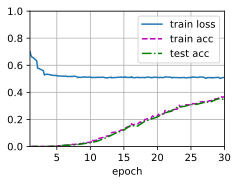

In [3]:
batch_size = 2048
data_dir = d2l.download_extract('ctr')
train_data = d2l.CTRDataset(os.path.join(data_dir, 'train.csv'))
test_data = d2l.CTRDataset(os.path.join(data_dir, 'test.csv'),
                           feat_mapper=train_data.feat_mapper,
                           defaults=train_data.defaults)
field_dims = train_data.field_dims
train_iter = gluon.data.DataLoader(
    train_data, shuffle=True, last_batch='rollover', batch_size=batch_size,
    num_workers=d2l.get_dataloader_workers())
test_iter = gluon.data.DataLoader(
    test_data, shuffle=False, last_batch='rollover', batch_size=batch_size,
    num_workers=d2l.get_dataloader_workers())
devices = d2l.try_all_gpus()
net = DeepFM(field_dims, num_factors=10, mlp_dims=[30, 20, 10])
net.initialize(init.Xavier(), ctx=devices)
lr, num_epochs, optimizer = 0.01, 30, 'adam'
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {'learning_rate': lr})
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

Comparado com FM, DeepFM converge mais rápido e atinge melhor desempenho.

## Sumário

* A integração de redes neurais ao FM permite modelar interações complexas e de alta ordem.
* DeepFM supera o FM original no conjunto de dados de publicidade.

## Exercícios

* Varie a estrutura do MLP para verificar seu impacto no desempenho do modelo.
* Mude o conjunto de dados para Criteo e compare-o com o modelo FM original.


[Discussão](https://discuss.d2l.ai/t/407)


<!--stackedit_data:
eyJoaXN0b3J5IjpbMTA5MjIyODY1MCwtMzU4MDA2NTA1XX0=
-->
